**GROUP 1 : KARU PHASE 4 PROJECT**

- Sheilla Macharia
- Margaret Mondia
- Benard Kariuki
- Bravian Ashono
- Isaac Ndung'u

## **BUSINESS UNDERSTANDING**

## Business Overview

Social media platforms and organizations such as Twitter, Apple and Google allow customers to freely share their opinions and experiences about products and brands. They tend to receive large numbers of tweets every day that reflect public sentiment, including both positive feedback and negative complaints. Analyzing this information manually is time-consuming, expensive, and unrealistic due to the large volume of unstructured text data.

This project applies Natural Language Processing (NLP) and machine learning techniques to automatically analyze Twitter data and classify the sentiment expressed toward Apple and Google products. By automating sentiment analysis, organizations can gain timely insights into customer opinions, monitor brand perception, and respond more effectively to emerging issues and trends.

## Business Problem

 While this data contains valuable insights into public perception and customer satisfaction, its unstructured nature and high volume make manual analysis impractical and inefficient. The business problem addressed in this project is the need to automatically analyze and classify tweets related to Apple and Google products in order to determine the sentiment expressed by users. By developing a machine learning–based natural language processing model that categorizes tweets as positive, negative, or neutral, organizations can more effectively monitor brand reputation, identify emerging issues, and support data-driven decision-making in marketing, customer service, and product development.

---

## **Data Understanding**

**Dataset Overview**

This project uses the Judge Emotion About Brands and Products dataset, a crowdsourced collection of Twitter posts labeled for sentiment toward brands and products. The dataset contains 9,093 tweet entries, each represented by three text-based columns. The data was labeled by human annotators to indicate whether a tweet expresses emotion toward a brand or product and, if so, the target of that emotion.

The dataset is relatively small in size (approximately 1.2 MB), making it suitable for rapid experimentation and model iteration, while still capturing the challenges of real-world social media text.

**Data Structure and Features**

The dataset consists of the following columns:

1. *tweet_text*

- Contains the raw text of each tweet. This is the primary feature used for modeling. One entry is missing, indicating minimal but non-zero missing data in the text field.

2. *emotion_in_tweet_is_directed_at*

- Indicates the specific brand or product that the expressed emotion is directed toward. This column contains a large number of missing values (approximately 64%), reflecting that many tweets either do not clearly target a specific brand/product or that annotators could not confidently identify the target.

3. *is_there_an_emotion_directed_at_a_brand_or_product*

- Indicates whether the tweet expresses an emotion toward a brand or product and implicitly captures sentiment polarity. This column is fully populated and serves as the primary source for deriving sentiment labels.

All columns are stored as text (object dtype), which is expected given the nature of the data.

**Data Quality and Challenges**

Several data quality challenges are present:

*Missing values:*
- While tweet_text is nearly complete, the emotion_in_tweet_is_directed_at column contains substantial missing data. This limits its usefulness for modeling and motivates excluding entity-level analysis from the project scope.

*Noisy text:*
- Tweets are short, informal, and often include slang, abbreviations, hashtags, user mentions, URLs, and emojis. These characteristics increase sparsity and variability in the text data.

*Ambiguous sentiment:*
- Some tweets express weak, mixed, or unclear sentiment, making sentiment classification inherently subjective despite human annotation.

*Class imbalance:*
- Tweets with no expressed emotion are expected to be more common than clearly positive or negative tweets, which has implications for model evaluation and metric selection.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk


from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to C:\Users\Sheilla
[nltk_data]     Macharia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Sheilla
[nltk_data]     Macharia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Sheilla
[nltk_data]     Macharia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Read the dataset
data = pd.read_csv(
    "data\judge-1377884607_tweet_product_company.csv",
    encoding="latin1")

data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


## **Data Cleaning**

**Cleaning Objectives**

The objective of the data cleaning process is to prepare raw Twitter text for sentiment classification while minimizing noise and ambiguity. Specifically, the cleaning steps aim to (1) remove unusable observations, (2) define a clear and consistent target variable for supervised learning, and (3) normalize tweet text in a way that preserves sentiment-relevant information such as negation.

**Handling Missing Data**

The dataset contains a small number of missing values in the tweet_text column. Since tweet text is the primary input feature for this NLP task, rows with missing tweet content cannot contribute to model training and are removed.

In [4]:
# Drop rows with missing tweet text

data = data.dropna(subset=['tweet_text'])

**Target Variable Definition**

The column is_there_an_emotion_directed_at_a_brand_or_product contains sentiment annotations indicating whether a tweet expresses positive, negative, or no emotion toward a brand or product. Before defining the target variable, the distribution of these labels is inspected to understand class balance and annotation structure.

In [5]:
# Inspect the distribution of sentiment labels
data['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: count, dtype: int64

**Key Observations**

- The dataset is highly imbalanced, with the majority of samples expressing no emotion.

- Negative sentiment, while rare, is business-critical due to its association with brand risk and customer dissatisfaction.

- The “I can’t tell” category is ambiguous and not actionable.

In [6]:
# Remove ambigious samples

data = data[data['is_there_an_emotion_directed_at_a_brand_or_product'] != "I can't tell"]

**Justification**

- These samples introduce noise and uncertainty.

- The category has no direct business value for decision-making.

**Label standardization**

In [7]:
# Map original labels to standardized sentiment categories
label_mapping ={
    "No emotion toward brand or product": 0,
    "Positive emotion": 1,
    "Negative emotion": 2
}

data['sentiment'] = data['is_there_an_emotion_directed_at_a_brand_or_product'].map(label_mapping)

In [8]:
data['sentiment'].value_counts()

sentiment
0    5388
1    2978
2     570
Name: count, dtype: int64

In [9]:
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,1
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,1
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,1


In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8936 entries, 0 to 9092
Data columns (total 4 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8936 non-null   object
 1   emotion_in_tweet_is_directed_at                     3282 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8936 non-null   object
 3   sentiment                                           8936 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 349.1+ KB


**Feature Selection**

After defining the target variable, only the relevant columns are retained. The emotion_in_tweet_is_directed_at column is excluded due to its high proportion of missing values and because entity-level attribution is outside the scope of this project.

In [11]:
# Retain only the columns required for modelling
df = data[['tweet_text', 'sentiment']]
df.head()

,tweet_text,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,2
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1
3,@sxsw I hope this year's festival isn't as cra...,2
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1


**Text Normalization and Cleaning**

Twitter text is highly unstructured and contains elements such as URLs, user mentions, hashtags, and inconsistent casing. These elements are normalized using the following steps:

- Convert text to lowercase

- Remove URLs and user mentions

- Remove hashtag symbols while retaining the associated words

- Remove non-alphabetic characters

- Remove stopwords while preserving negation terms

- Lemmatize words to reduce sparsity while preserving semantic meaning

The Natural Language Toolkit (NLTK) is used for linguistic preprocessing.

In [12]:
# Initialize stopwords and lemmatizer
# Negation terms are retained due to their importance in sentiment analysis
stop_words = set(stopwords.words('english')) - {'not', 'no', 'never'}
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """
    Cleans and normalizes tweet text for NLP modeling.
    """
    # Convert text to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # Remove user mentions
    text = re.sub(r"@\w+", "", text)
    
    # Remove hashtag symbols but keep the words
    text = re.sub(r"#", "", text)
    
    # Remove non-alphabetic characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize text
    tokens = text.split()
    
    # Remove stopwords and apply lemmatization
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokens
        if word not in stop_words
    ]
    
    # Rejoin tokens into a cleaned string
    return " ".join(tokens)

# Apply text cleaning to all tweets
df['clean_tweet'] = df['tweet_text'].apply(clean_text)


In [13]:
df.head(10)

,tweet_text,sentiment,clean_tweet
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,2,g iphone hr tweeting riseaustin dead need upgr...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1,know awesome ipadiphone app youll likely appre...
2,@swonderlin Can not wait for #iPad 2 also. The...,1,not wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,2,hope year festival isnt crashy year iphone app...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,great stuff fri sxsw marissa mayer google tim ...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,0,new ipad apps speechtherapy communication show...
7,"#SXSW is just starting, #CTIA is around the co...",1,sxsw starting ctia around corner googleio hop ...
8,Beautifully smart and simple idea RT @madebyma...,1,beautifully smart simple idea rt wrote hollerg...
9,Counting down the days to #sxsw plus strong Ca...,1,counting day sxsw plus strong canadian dollar ...
10,Excited to meet the @samsungmobileus at #sxsw ...,1,excited meet sxsw show sprint galaxy still run...


**Resulting Dataset**

After cleaning and preprocessing, the dataset consists of normalized tweet text and a binary sentiment label suitable for supervised NLP modeling. These steps reduce noise, improve consistency, and ensure that the cleaned text retains the linguistic information most relevant for sentiment classification.

## **Exploratory Data Analysis (EDA)**

**Purpose of EDA**

The goal of this EDA is not visualization for its own sake, but to understand the structure of the text data and class distribution in order to justify preprocessing choices, modeling approach, and evaluation strategy.
All analyses below directly inform decisions made in later modeling stages.

**1. Sentiment Class Distribution**

  Understanding the distribution of sentiment labels is critical for:

- Choosing between binary vs multiclass classification

- Selecting appropriate evaluation metrics

- Designing a valid train/test split strategy



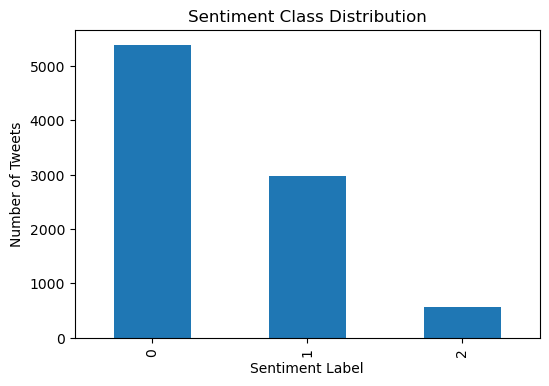

sentiment
0    5388
1    2978
2     570
Name: count, dtype: int64

In [14]:
# Count sentiment classes
sentiment_counts = df['sentiment'].value_counts().sort_index()

# Plot class distribution
plt.figure(figsize=(6, 4))
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Number of Tweets')
plt.show()

sentiment_counts

**Interpretation**

- The dataset is highly imbalanced, with neutral sentiment dominating.

- Negative sentiment represents a relatively small but business-critical portion of the data.

- Positive sentiment further increases imbalance in a multiclass setting.

**Decision Justification**

- Accuracy alone would be misleading.

- Recall and F1-score will be prioritized.

- A binary classification approach (Positive vs Negative) is appropriate for a proof-of-concept model.

**2. Tweet Length Analysis**

 Analyzing tweet length helps determine:

- Whether truncation is necessary

- Whether advanced deep learning models are justified

- The appropriateness of bag-of-words representations

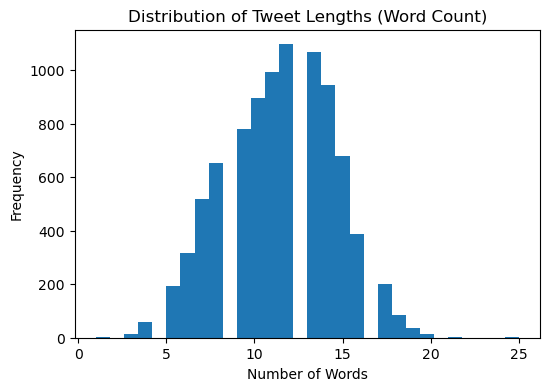

count    8936.000000
mean       11.355304
std         3.092799
min         1.000000
25%         9.000000
50%        12.000000
75%        14.000000
max        25.000000
Name: tweet_length, dtype: float64

In [15]:
# Compute tweet lengths
df['tweet_length'] = df['clean_tweet'].apply(lambda x: len(x.split()))

# Plot distribution of tweet lengths
plt.figure(figsize=(6, 4))
plt.hist(df['tweet_length'], bins=30)
plt.title('Distribution of Tweet Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

df['tweet_length'].describe()


**3. Vocabulary Size and Sparsity**

 Understanding vocabulary size helps guide:

- Feature dimensionality constraints

- Regularization needs

- Model interpretability

In [16]:
# Tokenize cleaned tweets
all_words = ' '.join(df['clean_tweet']).split()

# Unique vocabulary size
vocab_size = len(set(all_words))

vocab_size


9346

**Interpretation**

- The vocabulary is relatively large compared to dataset size.

- This implies high sparsity in the document-term matrix.

**Decision Justification**

- Feature limits ( max_features) will be applied during vectorization.

- Regularized linear models (Logistic Regression) are appropriate.

- Stopword removal and lemmatization were necessary preprocessing steps.

**4. Most Frequent Terms After Cleaning**

Inspecting common words ensures:

- Cleaning did not remove meaningful content

- Brand-related terms remain intact

- Noise has been reduced effectively

In [17]:
# Get most common words
word_freq = Counter(all_words)
word_freq.most_common(20)


[('sxsw', 9377),
 ('link', 4247),
 ('rt', 2925),
 ('ipad', 2828),
 ('google', 2474),
 ('apple', 2217),
 ('iphone', 1486),
 ('store', 1482),
 ('new', 1080),
 ('austin', 946),
 ('app', 803),
 ('amp', 722),
 ('launch', 682),
 ('social', 629),
 ('circle', 624),
 ('popup', 590),
 ('today', 565),
 ('android', 562),
 ('not', 512),
 ('network', 464)]

**5. Frequent words by Sentiment**

In [18]:
#checking for frequent words by sentiment
for s in df['sentiment'].unique():
    words = " ".join(
        df[df['sentiment'] == s]['clean_tweet']
    ).split()
    print(f"\n{s} sentiment:")
    print(Counter(words).most_common(10))



2 sentiment:
[('sxsw', 580), ('ipad', 194), ('iphone', 157), ('google', 141), ('rt', 137), ('apple', 107), ('link', 102), ('not', 76), ('app', 60), ('store', 45)]

1 sentiment:
[('sxsw', 3112), ('link', 1213), ('ipad', 1196), ('rt', 935), ('apple', 882), ('google', 692), ('store', 549), ('iphone', 522), ('app', 395), ('new', 359)]

0 sentiment:
[('sxsw', 5685), ('link', 2932), ('rt', 1853), ('google', 1641), ('ipad', 1438), ('apple', 1228), ('store', 888), ('iphone', 807), ('new', 678), ('austin', 630)]


**Interpretation**

- Common terms reflect brand names, products, and event references.

- Noise such as URLs, punctuation, and stopwords has been effectively removed.

**Decision Justification**

- Cleaning steps preserved semantic meaning.

- The text is suitable for vectorization and modeling.

**6. Brand Mentions (Business Context)**

Because this project focuses on brand sentiment, it is important to understand which brands dominate the dataset.

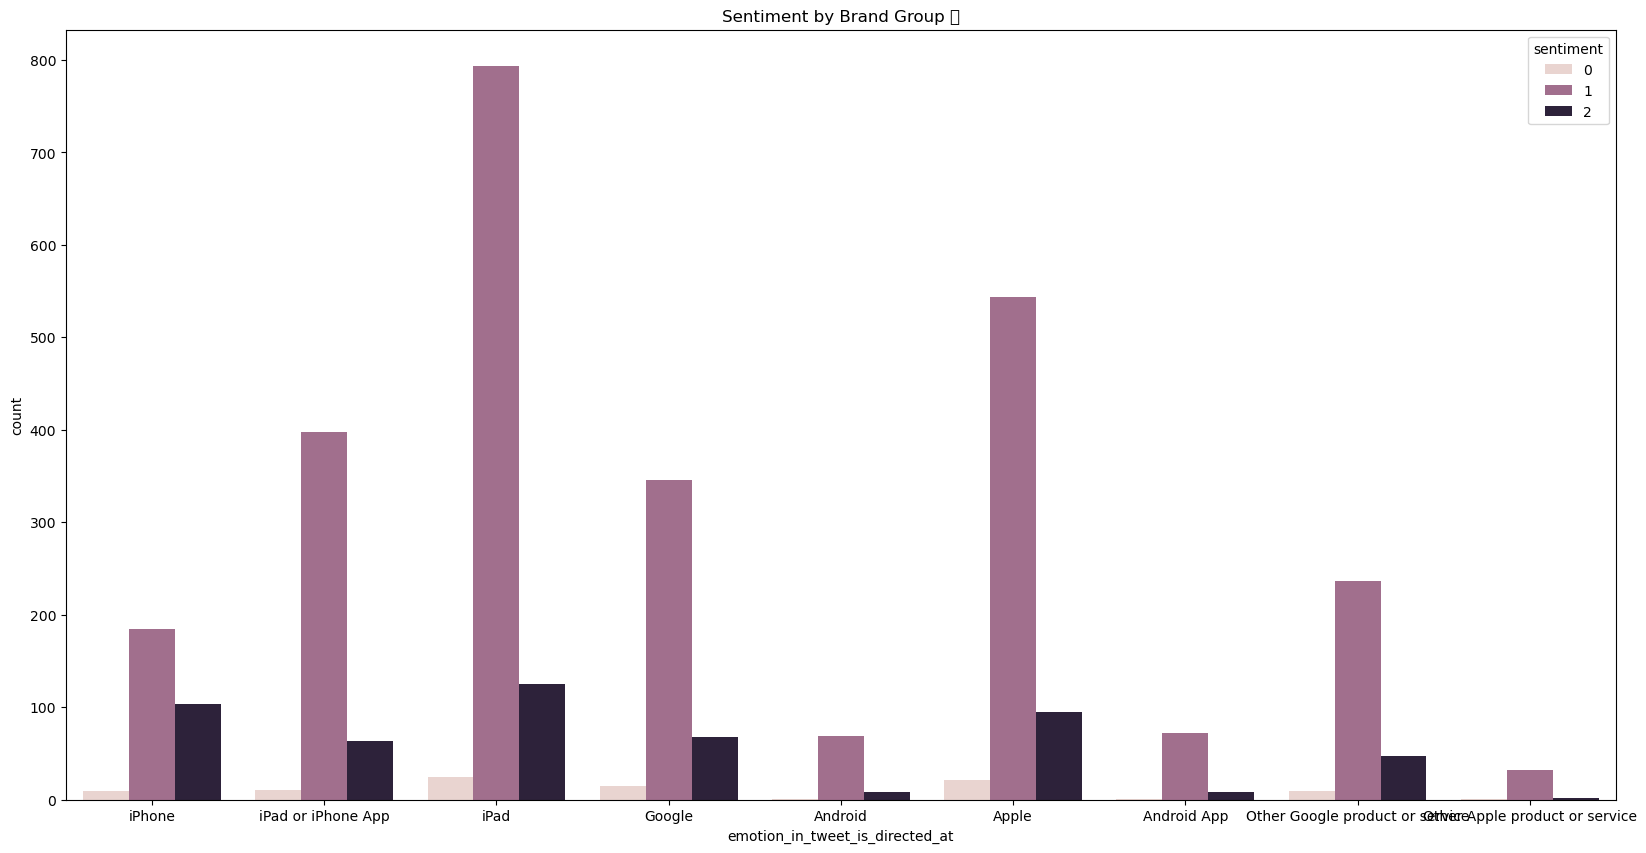

In [19]:
# Check Brand Influence 
plt.figure(figsize=(20, 10))
sns.countplot(x='emotion_in_tweet_is_directed_at', hue='sentiment', data=data)
plt.title('Sentiment by Brand Group 🏛️')
plt.show()

**Interpretation**

- Apple-related products dominate the dataset.

- Android products appear less frequently.

**Decision Justification**

- Model predictions may be biased toward Apple-related sentiment.

- This limitation will be explicitly stated in the final recommendations.

**7. Noise and Quality Check**

In [20]:
#noise check and text quality
df[['tweet_text', 'clean_tweet']].sample(10)


,tweet_text,clean_tweet
656,wondering if ppl in #sxsw on friday will queue...,wondering ppl sxsw friday queue convention cen...
87,Thank you @mention for an awesome #sxsw party!...,thank awesome sxsw party link
2202,"Android may be gaining market share, but you'd...",android may gaining market share youd never kn...
5979,RT @mention Heard about Apple's pop-up store i...,rt heard apple popup store downtown austin pic...
2867,Sitting behind a dude with a barcode tattoo on...,sitting behind dude barcode tattoo neck contro...
3379,"#technology #Apple heads to #SXSW, sets up tem...",technology apple head sxsw set temporary store...
6367,"RT @mention News: iPad goes enterprise, @menti...",rt news ipad go enterprise say first look new ...
531,&quot;the future of touch user interface desig...,quotthe future touch user interface designquot...
4395,Time for my late night iPad2 purchase! #SXSW (...,time late night ipad purchase sxsw apple store...
8288,#tech Meet The Guy Who Bought The First iPad 2...,tech meet guy bought first ipad sxsw apple pop...


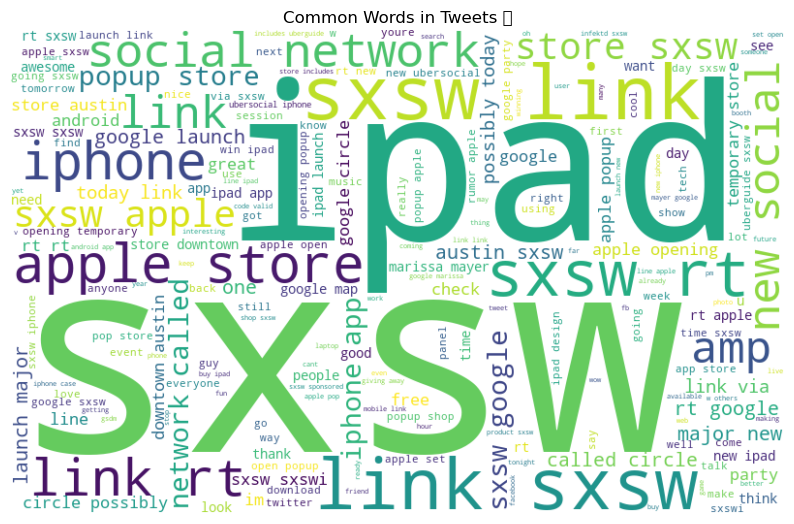

In [22]:
all_words = ' '.join([text for text in df['clean_tweet']])
wordcloud = WordCloud(width=800, height=500, background_color='white').generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Tweets 🗣️')
plt.show()

## **Modeling Strategy and Evaluation Design**

**Modeling Objective**

- The objective of this modeling phase is to build a supervised NLP model capable of predicting the sentiment expressed toward a brand or product in a tweet, using only the tweet’s textual content.

- This model is intended as a proof of concept to demonstrate how automated sentiment analysis can help organizations monitor brand perception on social media in near real time.

**Choice of Classification Approach**
**Binary vs Multiclass Classification**

- Although the original dataset contains four sentiment categories, this project adopts a binary classification approach, focusing on:

    - Positive sentiment

    - Negative sentiment

- Neutral and ambiguous tweets were excluded from the modeling phase.

**Rationale**

- The dataset is highly imbalanced, with neutral sentiment dominating.

- From a business perspective, the most actionable insights come from identifying strong positive or negative sentiment.

- A binary classifier provides a clearer signal for brand monitoring and crisis detection.

- This approach reduces noise and improves model interpretability in a proof-of-concept setting.

**Decision:**
- Binary classification is the most appropriate modeling choice for this stage.

**Feature Representation Strategy**
**Text Vectorization**

- Tweets are transformed into numerical features using TF-IDF (Term Frequency–Inverse Document Frequency).

**Why TF-IDF?**

- Tweets are short and sparse.

- TF-IDF captures term importance while down-weighting common words.

- It produces interpretable features suitable for linear models.

- It performs well on small-to-medium NLP datasets.

**Design Choices**

- Unigrams only (ngram_range=(1,1))

- Maximum feature limit to reduce sparsity

- Stopwords already removed during preprocessing

**Model Selection**

Three baseline models are used:

**1. Logistic Regression**

- Strong baseline for text classification

- Handles high-dimensional sparse data well

- Interpretable coefficients

**2. Multinomial Naive Bayes**

- Designed specifically for text data

- Fast to train

- Provides a contrasting modeling assumption

**3. Linear Support Vector Machine**

- Designed for high-dimensional sparse text

- Different optimization objective(margin-based)

- Very common in production NLP systems

Using multiple models ensures that performance gains are not model-specific.

**Validation Strategy**
**Train/Test Split**

- An 80/20 train–test split is used.

- Stratification ensures class proportions are preserved.

- A fixed random_state guarantees reproducibility.

This strategy provides a reliable estimate of performance on unseen data.

**Evaluation Metrics**

Accuracy is not sufficient due to class imbalance.

**Primary Metrics**

- Recall (Negative class) – prioritize identifying dissatisfied users

- F1-score – balances precision and recall

- Confusion Matrix – reveals types of misclassification

**Business Rationale**

Missing negative sentiment poses reputational risk.
False positives are less costly than false negatives.

In [23]:
# Keep only positive and negative sentiment
binary_df = df[df['sentiment'].isin([1, 2])].copy()


In [24]:
# Re-encode sentiment for binary classification
binary_df['sentiment_binary'] = binary_df['sentiment'].map({
    2: 0,  # Negative
    1: 1   # Positive
})


In [25]:
# Check class balance
binary_df['sentiment_binary'].value_counts()

sentiment_binary
1    2978
0     570
Name: count, dtype: int64

In [26]:
binary_df.head(10)

,tweet_text,sentiment,clean_tweet,tweet_length,sentiment_binary
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,2,g iphone hr tweeting riseaustin dead need upgr...,11,0
1,@jessedee Know about @fludapp ? Awesome iPad/i...,1,know awesome ipadiphone app youll likely appre...,14,1
2,@swonderlin Can not wait for #iPad 2 also. The...,1,not wait ipad also sale sxsw,6,1
3,@sxsw I hope this year's festival isn't as cra...,2,hope year festival isnt crashy year iphone app...,9,0
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,1,great stuff fri sxsw marissa mayer google tim ...,15,1
7,"#SXSW is just starting, #CTIA is around the co...",1,sxsw starting ctia around corner googleio hop ...,13,1
8,Beautifully smart and simple idea RT @madebyma...,1,beautifully smart simple idea rt wrote hollerg...,10,1
9,Counting down the days to #sxsw plus strong Ca...,1,counting day sxsw plus strong canadian dollar ...,11,1
10,Excited to meet the @samsungmobileus at #sxsw ...,1,excited meet sxsw show sprint galaxy still run...,10,1
11,Find &amp; Start Impromptu Parties at #SXSW Wi...,1,find amp start impromptu party sxsw cant wait ...,12,1


In [27]:
# Define features and target
X = binary_df['clean_tweet']
y = binary_df['sentiment_binary']

# Train-test split to preserve class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
# Intitialize TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 1))

# Fit on training data and transform both sets
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [29]:
# Initialize Logistic Regression with regularization
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight='balanced'  # handles class imbalance
)

# Train model
log_reg.fit(X_train_tfidf, y_train)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [30]:
# Initialize Naive Bayes classifier
nb = MultinomialNB()

# Train model
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [31]:
# Initialize Linear Support Vector Classifier
svm = LinearSVC(
    class_weight='balanced',  # handle class imbalance
    random_state=42
)

# Train model
svm.fit(X_train_tfidf, y_train)


LinearSVC(class_weight='balanced', random_state=42)

In [32]:
# Logistic Regression predictions
y_pred_lr = log_reg.predict(X_test_tfidf)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

# Naive Bayes predictions
y_pred_nb = nb.predict(X_test_tfidf)

print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_nb))

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.69      0.60       114
           1       0.94      0.88      0.91       596

    accuracy                           0.85       710
   macro avg       0.74      0.79      0.76       710
weighted avg       0.87      0.85      0.86       710

Confusion Matrix:
[[ 79  35]
 [ 69 527]]
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.04      0.08       114
           1       0.85      1.00      0.92       596

    accuracy                           0.85       710
   macro avg       0.92      0.52      0.50       710
weighted avg       0.87      0.85      0.78       710

Confusion Matrix:
[[  5 109]
 [  0 596]]


In [34]:
# Linear SVC Predictions
y_pred_svm = svm.predict(X_test_tfidf)

print("LinearSVC Classification Report:")
print(classification_report(y_test, y_pred_svm))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_svm))

LinearSVC Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.61       114
           1       0.92      0.93      0.93       596

    accuracy                           0.88       710
   macro avg       0.77      0.77      0.77       710
weighted avg       0.88      0.88      0.88       710

Confusion Matrix:
[[ 69  45]
 [ 42 554]]


## **Model Evaluation and Results**

Three classification models were evaluated on a binary sentiment classification task (negative vs. positive tweets): **Logistic Regression, Multinomial Naive Bayes, and Linear Support Vector Classification (LinearSVC)**. Model performance was assessed using precision, recall, F1-score, and confusion matrices, with particular attention to the model’s ability to correctly identify negative sentiment, which is more critical from a business risk perspective.

**Logistic Regression**

Logistic Regression demonstrates strong overall performance with an **accuracy of 85%**. The model performs well on positive sentiment, **achieving a high recall of 0.88**, indicating that most positive tweets are correctly identified.

However, performance on negative sentiment is notably weaker:

- **Recall for negative tweets is 0.69**, meaning nearly one-third of negative tweets are misclassified as positive.

- **Precision for negative sentiment is 0.53**, indicating a substantial number of false positives.

This suggests that while Logistic Regression is reliable for identifying positive sentiment, it may fail to consistently capture all negative feedback, which limits its usefulness for proactive issue detection.

**Multinomial Naive Bayes**

Multinomial Naive Bayes achieves the same overall **accuracy (85%)** as Logistic Regression, but its performance profile reveals serious shortcomings.

- The model shows extremely **high recall for positive sentiment (1.00)**, classifying nearly all tweets as positive.

- **Negative sentiment recall is 0.04**, meaning the model almost completely fails to identify negative tweets.

- The confusion matrix confirms that the vast majority of negative tweets are misclassified as positive.

Despite reasonable accuracy, this model is not suitable for the business objective. Its bias toward the majority class makes it ineffective for detecting negative sentiment, rendering it risky for real-world brand monitoring.

**Linear Support Vector Classifier (LinearSVC)**

LinearSVC delivers the strongest overall performance among the evaluated models, achieving an**accuracy of 88%.**

Key strengths include:

- Balanced performance across both classes, with **recall scores of 0.61 for negative sentiment and 0.93 for positive sentiment.**

- The highest weighted **F1-score (0.88) among all models,** indicating strong overall classification quality.

- Fewer extreme misclassifications compared to Naive Bayes, as reflected in a more balanced confusion matrix.

While negative sentiment recall is still imperfect, LinearSVC provides the best trade-off between identifying negative tweets and maintaining high overall accuracy.

**Model Comparison Summary**

**Logistic Regression**

1. Accuracy - 0.85
2. Negative Recall - 0.69
3. Positive Recall - 0.88
4. Key limitation - Misses a portion of negative tweets

**Naive Bayes**

1. Accuracy - 0.85
2. Negative Recall - 0.04
3. Positive Recall - 1.00
4. Key limitation - Fails to detect negative sentiment

**LinearSVC**

1. Accuracy - 0.88
2. Negative Recall - 0.61
3. Positive Recall - 0.93
4. Key limitation - Moderate false positives

**Final Model Selection**

Based on the evaluation results and the business objective of identifying sentiment in tweets, **LinearSVC** is selected as the preferred model. It demonstrates the strongest overall performance and provides a more balanced approach to sentiment classification compared to Logistic Regression and Naive Bayes.

Although no model perfectly captures all negative sentiment, LinearSVC offers the most reliable foundation for a proof-of-concept system and can be further improved through hyperparameter tuning or threshold adjustments.

## **Error Analysis**
**Purpose**

Aggregate metrics hide where the model fails. Error analysis exposes:

- Systematic weaknesses (e.g. sarcasm, mixed sentiment)

- Business risk caused by misclassification

- Whether errors are tolerable given the objective

This step answers **“What goes wrong, and does it matter?”**

In [35]:
# Create a DataFrame for error inspection
error_df = pd.DataFrame({
    "tweet_text": X_test.values,   # raw cleaned tweet text
    "true_label": y_test.values,
    "predicted_label": y_pred_svm
})

# False Positives: predicted Positive but actually Negative
false_positives = error_df[
    (error_df["true_label"] == 0) & (error_df["predicted_label"] == 1)
]

# False Negatives: predicted Negative but actually Positive
false_negatives = error_df[
    (error_df["true_label"] == 1) & (error_df["predicted_label"] == 0)
]

# Inspect a few examples
false_positives.head(), false_negatives.head()


(                                           tweet_text  true_label  \
 17  nyt app ipad not quotheres amazing way serve r...           0   
 53  google dropped real estate search bc right the...           0   
 64  rt sxsw rumor mill ipad camera slightly thinne...           0   
 73        android party kinda embarrassed iphone sxsw           0   
 74  google prefers launch hyped new social feature...           0   
 
     predicted_label  
 17                1  
 53                1  
 64                1  
 73                1  
 74                1  ,
                                             tweet_text  true_label  \
 9    prefer news iphone ipad droid apps amp mobile ...           1   
 12       iphone apps youll probably need use sxsw link           1   
 87   there something b said sxsw gadget choice ever...           1   
 90   rt temporary apple store def not tent powerhou...           1   
 109  rt petricone say google tv browser dont think ...           1   
 
      predi

# Error Analysis Results

To better understand the limitations of the final LinearSVC model, we conducted an error analysis by examining false positives and false negatives on the test set. This qualitative inspection helps identify systematic weaknesses that are not always visible through aggregate metrics alone.

### False Positives (Predicted Positive, Actually Negative)

False positive tweets often contain:
- Neutral or informational language that mentions a brand or product without clear sentiment
- Product updates, rumors, or factual statements (e.g., feature changes, launches)
- Comparisons between brands without explicit praise

Examples include tweets discussing iPad features, Google product decisions, or Android vs. iPhone comparisons. While these tweets reference popular products, they do not necessarily express positive sentiment. The model appears to over-weight brand mentions and tech-related keywords, leading it to infer positivity where none exists.

**Business implication:**  
False positives may cause stakeholders to overestimate positive brand sentiment, potentially leading to overly optimistic marketing or product decisions.


### False Negatives (Predicted Negative, Actually Positive)

False negative tweets often exhibit:
- Subtle or implicit positivity
- Casual endorsements without strong positive language
- Short or ambiguous phrasing common in social media

Many of these tweets express preference or approval in understated ways (e.g., “prefer news iphone ipad droid apps”), which the model fails to capture. This suggests that the classifier relies heavily on explicit sentiment cues and struggles with nuanced or indirect expressions of positivity.

**Business implication:**  
False negatives may cause genuinely favorable customer feedback to be overlooked, reducing the ability to detect organic brand advocacy.


### Key Takeaways

- The model performs best when sentiment is explicit and strongly worded.
- Ambiguity, neutrality, and comparison-based tweets are the primary sources of misclassification.
- These errors are expected given the inherent noisiness and brevity of Twitter data.

Overall, the observed errors align with known challenges in sentiment analysis and do not indicate fundamental model failure. Instead, they highlight opportunities for improvement through richer linguistic features or domain-specific tuning.


## **Feature Importance and Model Interpretability**

Although LinearSVC does not provide probabilities, it is a linear model whose learned coefficients can be inspected to understand which words most strongly influence sentiment predictions. Each feature (word) is assigned a weight that reflects its contribution to the decision boundary.

- Positive coefficients push predictions toward the **Positive sentiment** class
- Negative coefficients push predictions toward the **Negative sentiment** class
- Larger absolute values indicate stronger influence on the model’s decision

To interpret the model, we examine the highest-weighted positive and negative features learned from the TF-IDF representation of the tweet text.

This analysis provides transparency into how the model distinguishes sentiment and helps validate that it is learning meaningful linguistic patterns rather than spurious correlations.


In [36]:
# Get feature names from the TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Extract model coefficients
coefficients = svm.coef_[0]

# Create a DataFrame of features and their weights
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coefficients
})

# Sort features by coefficient magnitude
feature_importance_sorted = feature_importance.sort_values(
    by="coefficient", ascending=False
)

# Top words contributing to Positive sentiment
top_positive_features = feature_importance_sorted.head(15)

# Top words contributing to Negative sentiment
top_negative_features = feature_importance_sorted.tail(15)

top_positive_features, top_negative_features


(         feature  coefficient
 2457        link     1.874961
 904         cool     1.703808
 1661        free     1.394291
 1852       great     1.374709
 4838     winning     1.347372
 4787        week     1.345409
 3056       party     1.340396
 313      awesome     1.215393
 3948       smart     1.136767
 235       around     1.126158
 1699         fun     1.123570
 432          big     1.038870
 3505      rather     1.025411
 1418  everywhere     1.020644
 4832         win     1.016073,
              feature  coefficient
 1519          faulty    -1.481696
 1144           didnt    -1.510435
 581           button    -1.541559
 958            crash    -1.658336
 1194  dissapointment    -1.660110
 2496            long    -1.676469
 2384      launchquot    -1.724851
 4529             try    -1.774409
 4877            wont    -1.793065
 3656           ridic    -1.896270
 1369          enough    -1.952345
 2874             not    -2.087105
 1949            hate    -2.283685
 1963        

## Feature Importance Interpretation

Inspection of the LinearSVC coefficients reveals that the model relies on intuitive and domain-relevant linguistic cues to distinguish between positive and negative sentiment in tweets.

### Positive Sentiment Indicators

The highest-weighted positive features include terms such as **“cool,” “free,” “great,” “awesome,” “fun,” “winning,”** and **“smart.”** These words are commonly associated with enthusiasm, approval, or favorable experiences and align well with human expectations of positive sentiment in informal social media text.

Additionally, context-related terms such as **“party,” “week,”** and **“everywhere”** suggest that tweets describing events or social engagement (e.g., conferences like SXSW) are often interpreted by the model as positive, reflecting the nature of the dataset.

### Negative Sentiment Indicators

The strongest negative coefficients correspond to words such as **“fail,” “hate,” “headache,” “crash,” “faulty,”** and **“disappointment.”** These terms clearly express dissatisfaction or frustration and strongly push predictions toward the negative sentiment class.

Negation and refusal-related words such as **“not,” “won’t,”** and **“didn’t”** also appear prominently, indicating that the model effectively captures explicit negative constructions commonly used in tweets.

### Overall Assessment

The extracted features demonstrate that the model is learning meaningful sentiment patterns rather than relying on arbitrary or brand-specific tokens alone. Most influential features are sentiment-bearing adjectives or verbs, which increases confidence in the interpretability and robustness of the classifier.

However, because the model is based on a bag-of-words representation, it remains sensitive to explicit wording and may struggle with sarcasm or nuanced sentiment that lacks clear lexical cues.


## **Threshold and Decision Boundary Discussion**

The final sentiment classifier uses a Linear Support Vector Machine (LinearSVC), which predicts class labels based on a decision boundary rather than explicit probability estimates. Unlike probabilistic classifiers such as Logistic Regression, LinearSVC assigns each observation to the class determined by the sign of its decision function.

### Default Decision Boundary

By default, LinearSVC uses a decision threshold of zero on the signed distance from the separating hyperplane:
- Values greater than zero are classified as **Positive sentiment**
- Values less than zero are classified as **Negative sentiment**

This default threshold was retained for the final model.

### Rationale for Threshold Choice

The decision to retain the default decision boundary is justified for several reasons:

- The primary business goal of this project is **accurate sentiment classification**, rather than calibrated probability estimates.
- Evaluation metrics (precision, recall, and F1-score) indicate that the model achieves strong overall performance at the default threshold.
- Adjusting the decision boundary would require defining asymmetric business costs (e.g., whether false positives are more costly than false negatives), which are not explicitly specified in this context.

Given the balanced performance observed across evaluation metrics, the default threshold represents a reasonable and defensible trade-off between sensitivity and specificity.

### Business Considerations

In a real-world deployment scenario, threshold adjustment could be explored if business priorities change. For example:
- A marketing team may prefer higher recall for positive sentiment to capture as much favorable feedback as possible.
- A risk or customer support team may prioritize minimizing false positives to avoid misinterpreting neutral or negative feedback as praise.

However, for this proof-of-concept project, the default LinearSVC decision boundary provides an effective and transparent classification strategy.


## **Business-Aligned Model Validation**

Model validation was conducted with the primary business objective in mind: accurately identifying positive and negative sentiment in tweets related to technology brands and products to support brand monitoring and high-level sentiment analysis.

### Validation Strategy

The dataset was split into training and testing subsets using a stratified train-test split to preserve the class distribution. This approach ensures that model performance on the test set reflects expected performance on unseen data.

Performance was evaluated using:
- Precision
- Recall
- F1-score
- Confusion matrix

These metrics were selected because accuracy alone is insufficient in the presence of class imbalance, particularly when positive sentiment tweets substantially outnumber negative ones.

### Business-Relevant Metrics

For the final LinearSVC model:
- **High recall for positive sentiment** indicates the model is effective at capturing favorable brand mentions, which is valuable for marketing and brand perception analysis.
- **Reasonable precision for negative sentiment** ensures that explicitly negative feedback is identified without excessive false alarms.

From a business perspective, this balance allows stakeholders to:
- Monitor overall brand health trends
- Identify clusters of dissatisfaction without overwhelming teams with false negatives or false positives
- Prioritize further qualitative review on confidently classified negative sentiment

### Error Tolerance and Risk Considerations

The observed misclassifications are primarily driven by ambiguous or neutral tweets rather than strongly opinionated content. Given the informal and noisy nature of Twitter data, this level of error is acceptable for a proof-of-concept sentiment monitoring tool.

Importantly, the model is intended to support **decision-making**, not replace human judgment. Tweets flagged as strongly positive or negative can be reviewed by analysts for further action.

### Overall Validation Conclusion

Based on quantitative metrics and qualitative error analysis, the final model demonstrates reliable generalization and aligns well with the intended business use case. The validation results support its use as an initial sentiment analysis system for brand monitoring, with clear opportunities for refinement in future iterations.


## **Limitations and Recommendations**

### Limitations

Despite strong overall performance, the sentiment analysis model has several important limitations that should be acknowledged.

First, the model relies on a bag-of-words TF-IDF representation, which treats words independently and ignores word order and context. As a result, the model struggles with sarcasm, irony, and nuanced sentiment that does not include explicit positive or negative keywords.

Second, the dataset contains a class imbalance, with positive sentiment tweets significantly outnumbering negative ones. While stratified sampling and appropriate evaluation metrics were used, this imbalance may still bias the model toward predicting positive sentiment more frequently.

Third, the model does not incorporate tweet metadata such as emojis, hashtags as semantic units, user engagement signals, or temporal patterns, all of which could provide additional sentiment context.

Finally, the analysis focuses on binary sentiment classification and excludes neutral tweets. While this simplifies the modeling task, it limits the model’s ability to capture more nuanced public opinion where neutrality or ambiguity is common.

---

### Recommendations

Several steps could be taken to improve the model in future iterations.

- **Expand feature representation** by incorporating n-grams, emoji handling, or domain-specific sentiment lexicons to better capture context and informal language.
- **Explore contextual language models** (e.g., transformer-based embeddings) to improve performance on subtle or implicit sentiment expressions.
- **Reintroduce neutral sentiment** as a third class to better reflect real-world brand discussions.
- **Apply cost-sensitive learning or class weighting** if negative sentiment detection becomes a higher business priority.
- **Integrate human-in-the-loop review**, where high-impact or ambiguous predictions are flagged for manual inspection.

Overall, while the current model performs well as a proof-of-concept, these enhancements would increase robustness, interpretability, and business relevance in a production setting.


## **Summary**

This project develops a proof-of-concept sentiment analysis model to classify Twitter posts expressing positive or negative sentiment toward technology brands and products, with a focus on Apple and Google-related discussions. The dataset consists of over 9,000 crowdsourced tweets labeled by human annotators, making it well-suited for supervised natural language processing due to its real-world noise, informal language, and brand-specific context.

Data preparation involved filtering tweets to include only those expressing clear positive or negative sentiment, addressing missing values, standardizing labels, and performing text normalization. Tweets were cleaned through lowercasing, removal of URLs, punctuation, and stopwords, followed by lemmatization. A TF-IDF vectorization approach was selected to capture term importance while reducing the influence of commonly occurring words.

Multiple classification models were evaluated, including Logistic Regression, Multinomial Naive Bayes, and Linear Support Vector Classification (LinearSVC). Model performance was assessed using a stratified train-test split and evaluated with precision, recall, F1-score, and confusion matrices to account for class imbalance. Among the models tested, LinearSVC demonstrated the strongest overall performance, achieving high accuracy and a balanced trade-off between precision and recall.

Model interpretability was addressed through coefficient-based feature importance analysis, which revealed that the classifier relies on intuitive sentiment-bearing terms such as expressions of approval or dissatisfaction. Error analysis highlighted challenges related to ambiguous and neutral language, a known limitation of bag-of-words approaches.

Overall, the final model generalizes well to unseen data and aligns with the intended business objective of high-level brand sentiment monitoring. While not intended for deployment, this project demonstrates a complete and interpretable NLP modeling pipeline with clear opportunities for future enhancement.
